In [1]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("DESeq2")
library(DESeq2)
library(gplots)
library(RColorBrewer)
library(calibrate)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

In [2]:
countdata = read.csv('../results/KvsNAC.csv', header=TRUE, row.names=1)
countdata = as.matrix(countdata)
head(countdata)

,kontrol1,kontrol2,kontrol3,NAC1,NAC2,NAC3
WBGene00000001,507,689,538,1447,719,682
WBGene00000002,39,55,45,201,47,81
WBGene00000003,48,40,24,189,83,75
WBGene00000004,177,104,125,728,197,211
WBGene00000005,39,50,63,89,59,45
WBGene00000006,21,23,16,96,45,20


In [3]:
(condition = factor(c(rep("kontrol",3), rep("NAC",3))))

[1] kontrol kontrol kontrol NAC     NAC     NAC    
Levels: kontrol NAC

In [4]:
(coldata = data.frame(row.names=colnames(countdata), condition))

,condition
kontrol1,kontrol
kontrol2,kontrol
kontrol3,kontrol
NAC1,NAC
NAC2,NAC
NAC3,NAC


In [5]:
dds = DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

class: DESeqDataSet 
dim: 46748 6 
metadata(1): version
assays(1): counts
rownames(46748): WBGene00000001 WBGene00000002 ... WBGene00255587
  WBGene00255588
rowData names(0):
colnames(6): kontrol1 kontrol2 ... NAC2 NAC3
colData names(1): condition

In [6]:
# (dds$condition = relevel(dds$condition, ref="norm"))

ERROR: Error in relevel.factor(dds$condition, ref = "norm"): 'ref' must be an existing level


In [7]:
dds = DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


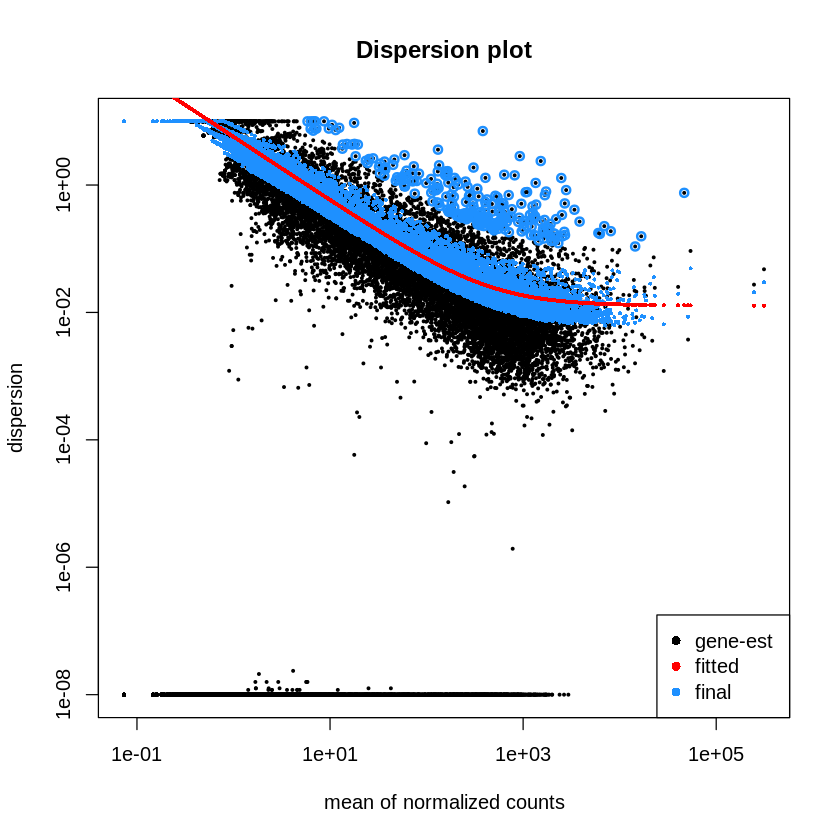

In [8]:
plotDispEsts(dds, main="Dispersion plot")

In [9]:
rld = rlogTransformation(dds)

In [10]:
head(assay(rld))

,kontrol1,kontrol2,kontrol3,NAC1,NAC2,NAC3
WBGene00000001,9.358873,9.520372,9.566305,9.365441,9.443765,9.566216
WBGene00000002,5.916463,5.996250,6.037530,6.192662,5.884499,6.208747
WBGene00000003,5.963297,5.837858,5.777335,6.125218,6.096541,6.133389
WBGene00000004,7.733877,7.267991,7.591731,8.046798,7.617891,7.806888
WBGene00000005,5.746548,5.787986,6.025474,5.658533,5.806121,5.769045
WBGene00000006,4.889034,4.876948,4.864943,5.031902,5.032640,4.859218


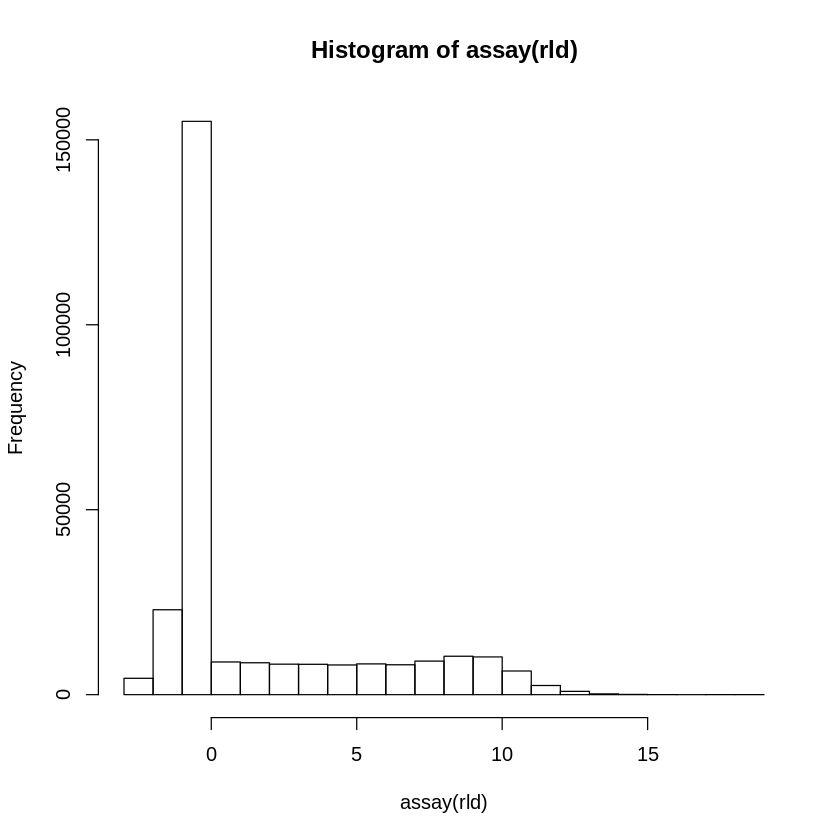

In [11]:
hist(assay(rld))

In [12]:
(mycols = brewer.pal(8, "Dark2")[1:length(unique(condition))])

[1] "#1B9E77" "#D95F02"

In [13]:
sampleDists = as.matrix(dist(t(assay(rld))))

Warning message in plot.window(...):
“"key" is not a graphical parameter”Warning message in plot.window(...):
“"trace" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"key" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"trace" is not a graphical parameter”Warning message in title(...):
“"key" is not a graphical parameter”Warning message in title(...):
“"trace" is not a graphical parameter”

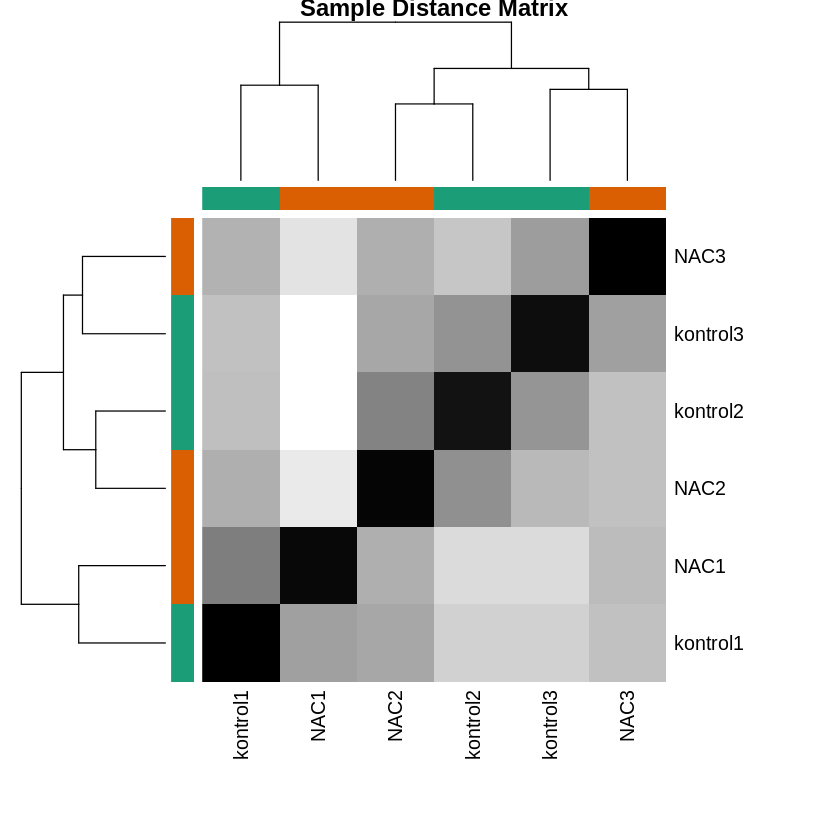

In [15]:
heatmap(as.matrix(sampleDists), key=F, trace="none",
       col=colorpanel(100, "black", "white"),
       ColSideColors=mycols[condition], RowSideColor=mycols[condition],
       margin=c(10,10), main="Sample Distance Matrix")

In [16]:
rld_pca <- function (rld, intgroup = "condition", ntop = 500, colors=NULL, legendpos="bottomleft", main="PCA Biplot", textcx=1, ...) {
  require(genefilter)
  require(calibrate)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC2 (",as.character(pc2var),"%)")
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
  with(as.data.frame(pca$x), textxy(PC1, PC2, labs=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20)
  #     rldyplot(PC2 ~ PC1, groups = fac, data = as.data.frame(pca$rld),
  #            pch = 16, cerld = 2, aspect = "iso", col = colours, main = draw.key(key = list(rect = list(col = colours),
  #                                                                                         terldt = list(levels(fac)), rep = FALSE)))
}

Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:MASS’:

    area

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars



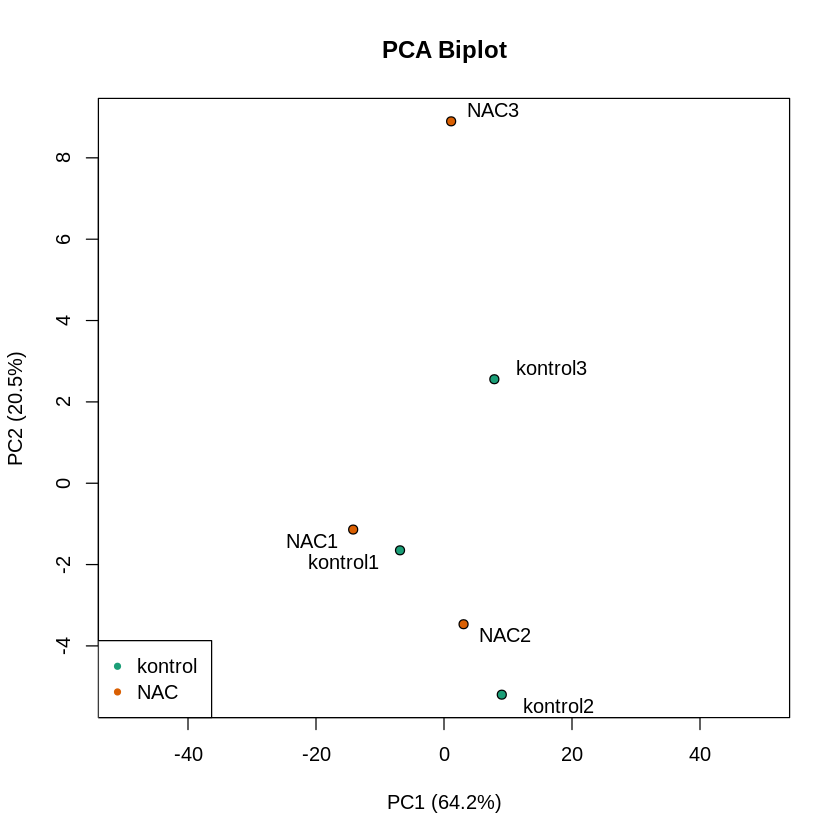

In [17]:
rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-50,50))

In [18]:
res = results(dds)

In [19]:
table(res$padj<0.05)


FALSE  TRUE 
22437     7 

In [20]:
res = res[order(res$padj),]
resdata = merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] = "Gene"
head(resdata)

Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,kontrol1,kontrol2,kontrol3,NAC1,NAC2,NAC3
WBGene00009431,283.27324,-1.4426959,0.2701333,-5.340681,9.259798e-08,0.002078269,304.006193,365.228127,571.971960,126.84695,141.12660,190.45959
WBGene00012683,180.32868,-1.5072082,0.3096783,-4.867013,1.132973e-06,0.012714224,264.136528,263.354406,276.525884,142.26238,74.88350,60.80939
WBGene00001824,290.11805,1.1647789,0.2537650,4.589991,4.432661e-06,0.024383196,166.954221,203.747442,167.370930,551.87234,334.09563,316.66775
WBGene00008647,22.74575,4.4186052,0.9716834,4.547371,5.432008e-06,0.024383196,0.000000,4.335052,1.455399,13.65367,47.04220,69.98816
WBGene00022644,781.95082,-0.7817045,0.1714317,-4.559861,5.118755e-06,0.024383196,930.707485,958.046482,1076.995549,516.63707,705.63300,503.68530
WBGene00018418,31.39273,2.8656459,0.6360170,4.505612,6.618178e-06,0.024756399,6.229635,5.418815,11.643195,89.40949,29.76139,45.89388


In [21]:
write.csv(resdata, file="../results/K_vs_NAC.deseq.csv")

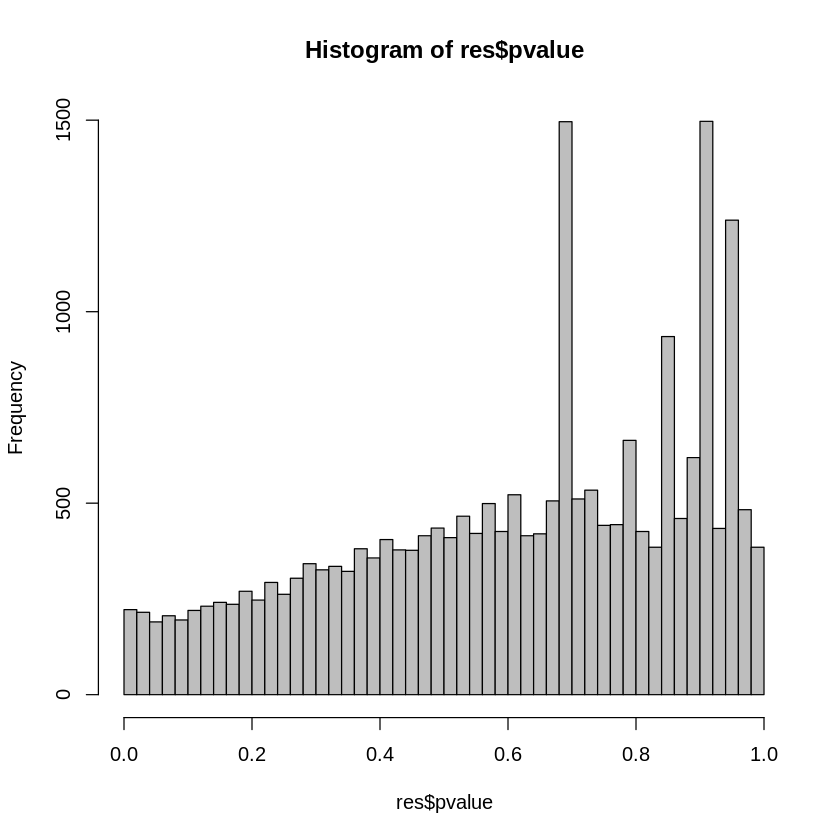

In [22]:
hist(res$pvalue, breaks=50, col="grey")

In [23]:
maplot <- function (res, thresh=0.05, labelsig=TRUE, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=Gene, cex=textcx, col=2))
  }
}

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“24288 x values <= 0 omitted from logarithmic plot”

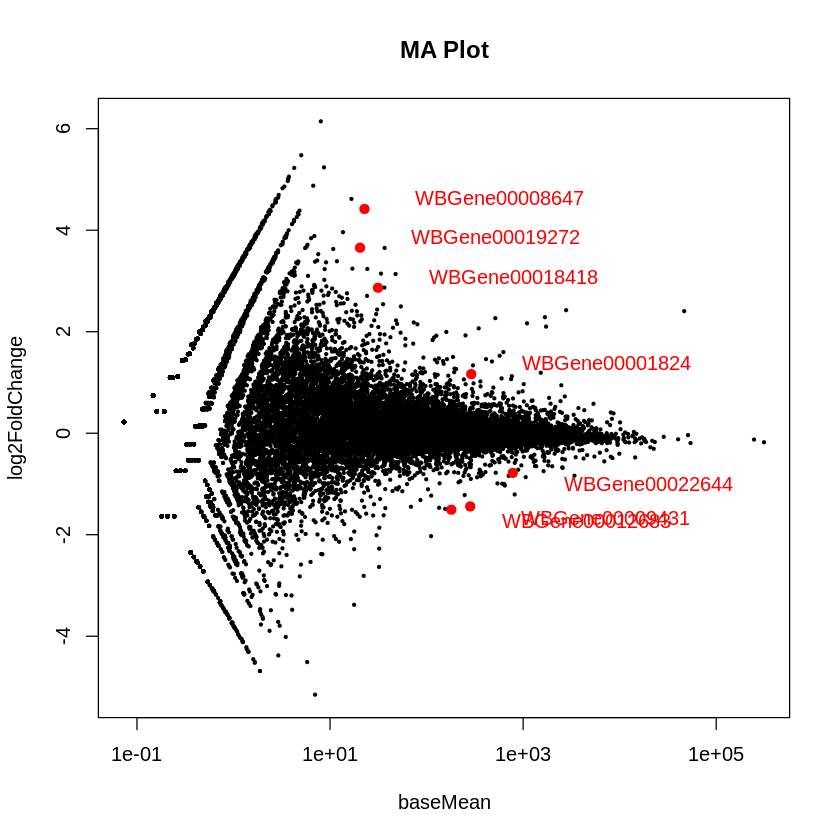

In [24]:
maplot(resdata, main="MA Plot")

In [25]:
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.05, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(pvalue), labs=Gene, cex=textcx, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}

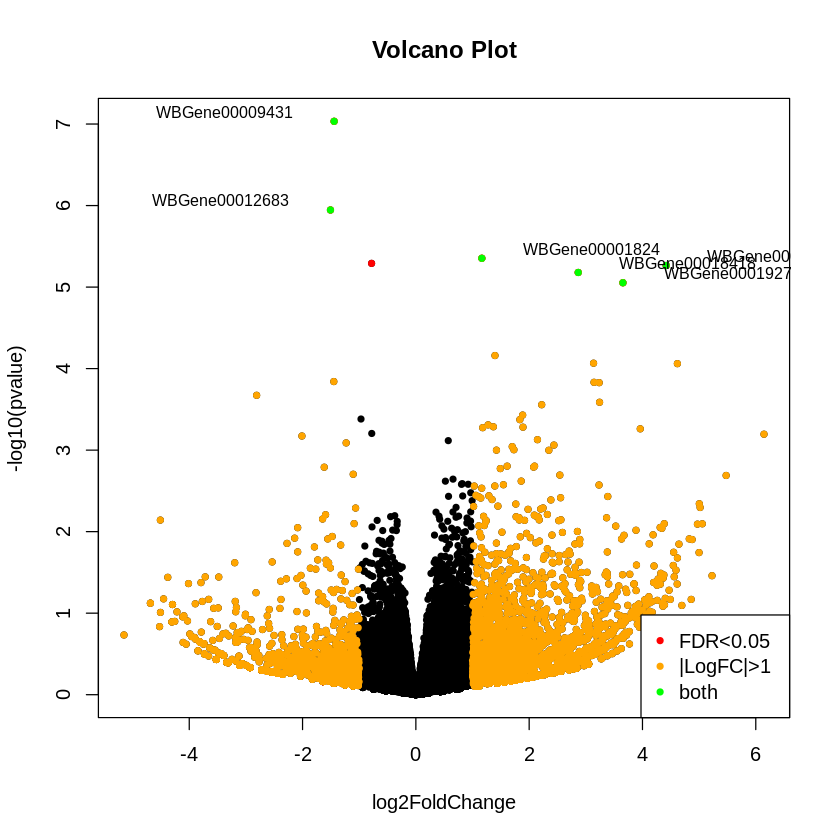

In [26]:
volcanoplot(resdata, lfcthresh=1, sigthresh=0.05, textcx=.8)